<a href="https://colab.research.google.com/github/Createdd/computervision_ue/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

available on 

## https://colab.research.google.com/drive/1UXrw17Lsbt-hsOIerbMG4JuFzpn73DWK

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/cv_data/

/content/drive/MyDrive/cv_data


In [4]:
!apt install unzip
# !unzip ./data_WiSAR.zip -d .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
%ls

data/  data_WiSAR.zip  integrated/


In [21]:
import torchvision
import torch
import torch.nn as nn

import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

# https://afagarap.github.io/2020/01/26/implementing-autoencoder-in-pytorch.html
# https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329
# https://manalelaidouni.github.io/Pytorch%20guide%20101.html

## Load data


In [39]:
from torchvision import datasets, transforms

data_dir = './data'
# DATA_DIR = 'data/train/train-1-0/0-B01.png'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)

# train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.5, 0.5, 0.5], 
#                                                            [0.5, 0.5, 0.5])])
train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                       transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       #transforms.Normalize([0.5, 0.5, 0.5], 
                                        #                   [0.5, 0.5, 0.5])
                                      transforms.Normalize([0.5], 
                                                           [0.5])])

train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', 
                                  transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           shuffle=True,
                                          batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, 
                                         batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_data, 
                                         batch_size=32)

In [40]:
train_data

Dataset ImageFolder
    Number of datapoints: 1820
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [41]:
def imshow(img):
    plt.figure(figsize=(10,8))
    plt.imshow(img.permute(1,2,0))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


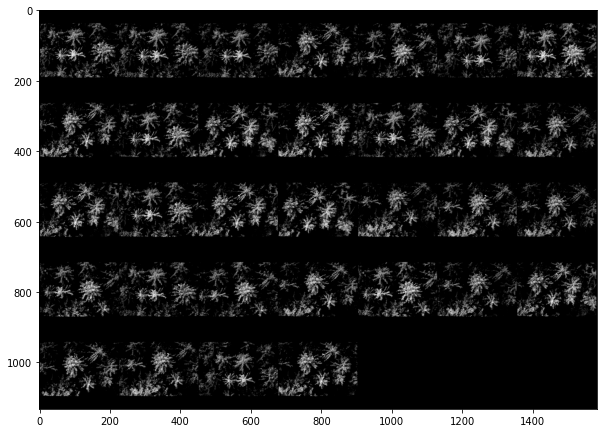

In [42]:
image, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(image,nrow=7))


In [22]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [23]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
!tensorboard --logdir=/tmp/autoencoder


2021-12-08 14:08:53.972372: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
trainloader

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(trainloader,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(testloader),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

ValueError: ignored